# Tutorial 5

In this tutorial, we'll look at time series and natural language processing.

```sh
$ uv add tensorflow gensim
```

In [ ]:
import numpy as np
import math
from matplotlib import pyplot as plt

import tensorflow as tf

print("Tensorflow version:", tf.__version__)

### The problem

Processing sequential data is mainly hard due to the fact that the sequences usually have differing lenghts and contain long-range dependencies, where in order to process a piece of the sequence, the relevant information is far away from it.

We'll showcase recurrent neural nets (RNNs) on the [IMDB movie review](http://ai.stanford.edu/~amaas/data/sentiment/) dataset containing comments (reviews) of movies. Each comment is a sequence of words (of varying lengths) and our goal is to predict the "sentiment" of the comment - i. e. whether it's a positive or a negative review. The dataset contains 25 000 training comments and 25 000 testing comments, however, we'll just use 5 000 due to the computational complexity.

The `keras` library contains this dataset among its built-in dataset. In the loaded dataset, words are represented by their numerical indices, which denote their frequency in the whole dataset, i. e. the word represetned by 2 is the second most common word.

In [ ]:
# We'll only keep the 3000 most frequent words and replace the rest with zeroes.
N = 3000
(Xtrain, Ytrain), (Xtest, Ytest) = tf.keras.datasets.imdb.load_data(num_words=N, index_from=2)
max_size = 5000
Xtrain = Xtrain[0:max_size]
Ytrain = Ytrain[0:max_size]
Xtest = Xtest[0:max_size]
Ytest = Ytest[0:max_size]

# Split data to into train and validation
from sklearn.model_selection import train_test_split
Xval, Xtest, Yval, Ytest = train_test_split(Xtest, Ytest, test_size=0.6, random_state=42)

In [ ]:
# Print shapes & content sample
print('Xtrain shape:', Xtrain.shape)
print('Xtest shape:', Xtest.shape)
print('Xval shape:', Xval.shape)

print('Xtrain example:', Xtrain[0])
print('Xtrain example:', Xtrain[1])

### Preporcessing

In order to be able to use mini-batch training, we'll pretrain the data to make all the sequences the same length by truncating longer ones and padding shorter ones with zeroes.

In [ ]:
# Visualizing lengths
lengths = np.vectorize(len)(Xtrain)
plt.hist(lengths, bins = 100)

In [ ]:
# Truncate and pad input sequences
max_review_length = 400
Xtrain = tf.keras.preprocessing.sequence.pad_sequences(Xtrain, maxlen=max_review_length)
Xval = tf.keras.preprocessing.sequence.pad_sequences(Xval, maxlen=max_review_length)
Xtest = tf.keras.preprocessing.sequence.pad_sequences(Xtest, maxlen=max_review_length)

In [ ]:
# Print shapes & observe content
print('Xtrain shape:', Xtrain.shape)
print('Xtest shape:', Xtest.shape)
print('Xval shape:', Xval.shape)

print('Xtrain example:', Xtrain[0,:])

### Recurrent neural network (RNN)

Let's construct a recurrent neural network, with 2 components:

- `keras.layers.Embedding` is a pseudo-layer, which embeds the works into vectors of a fixed length. It's a kind of dictionary of vector representations of the words which learns the representations. In our case, it converts `max_review_length` inputs into `max_review_length` vectors of length `embedding_vector_length`. There will be as many different vectors as there are words, i.e. `N`. THis layer will have $N_ $\cdot$ _embedding_vector_length$ parameters.
- `keras.layers.SimpleRNN` is a basic fully connected recurrent network. Each neuron is connected to all inputs and to all of the outputs of the previous step. If we have 100 neurons and a word vector length of 10, each neuron will be connected to 10 inputs representing the input word and 100 inputs that are the outputs of the previous step. If we add 1 bias, we get the number of parameters as $100 * (10 + 100 + 1) = 11 100$. By default, this layer uses tanh as its activation function.

In [ ]:
embedding_vector_length = 10

# Create a model
input_sequence = tf.keras.Input(shape=(max_review_length,))
embedding_sequence = tf.keras.layers.Embedding(input_dim = N, output_dim = embedding_vector_length, input_length = max_review_length)(input_sequence)
x = tf.keras.layers.SimpleRNN(100)(embedding_sequence)
y = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# TensorFlow model definition
model = tf.keras.Model(inputs=input_sequence, outputs=y)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer="adam", metrics=["accuracy"])

print(model.summary())

In [ ]:
# Train the model
history = model.fit(Xtrain, Ytrain, 
                    validation_data=(Xval, Yval), 
                    batch_size = 128, # default 32
                    epochs=10)

In [ ]:
# Evaluation
test_loss, test_acc = model.evaluate(Xtest, Ytest, verbose = 0)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

#### Evaluation
We get an accuracy of ~75%, which is not bad for such a complex task.

## LSTM

Another important milestone in the history of RNNs is the LSTM (long short-term memory) module. This module serves as a memory that can retain information across long-range dependencies.

For a very nice overview of LSTMs, see https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [ ]:
# Create a model
input_sequence = tf.keras.Input(shape=(max_review_length,))
embedding_sequence = tf.keras.layers.Embedding(input_dim = N, output_dim = embedding_vector_length, input_length = max_review_length)(input_sequence)
x = tf.keras.layers.LSTM(100)(embedding_sequence)
y = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# TensorFlow model definition
model = tf.keras.Model(inputs=input_sequence, outputs=y)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer="adam", metrics=["accuracy"])

print(model.summary())

In [ ]:
# Train the model
history = model.fit(Xtrain, Ytrain, 
                    validation_data=(Xval, Yval), 
                    batch_size = 128, # default 32
                    epochs=5)

In [ ]:
# Evaluation
test_loss, test_acc = model.evaluate(Xtest, Ytest, verbose = 0)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

#### Evaluation
We can see a significatnt improvement over a basic RNN.

# word2vec

In thze previous examples, we used the keras `Embedding` layer to transform words into vectors of a fixed length. A more modern alternative is the word2vec method, which is basically a pre-trained neural-net and we use its outputs as the word embeddings:

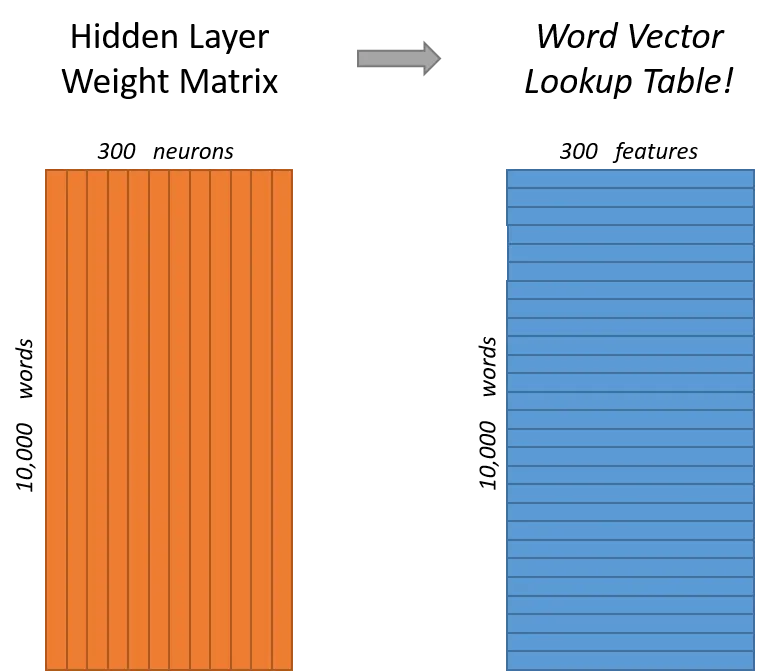

([source](https://medium.com/@manansuri/a-dummys-guide-to-word2vec-456444f3c673))

In the latent space, each dimension carries semantic information:

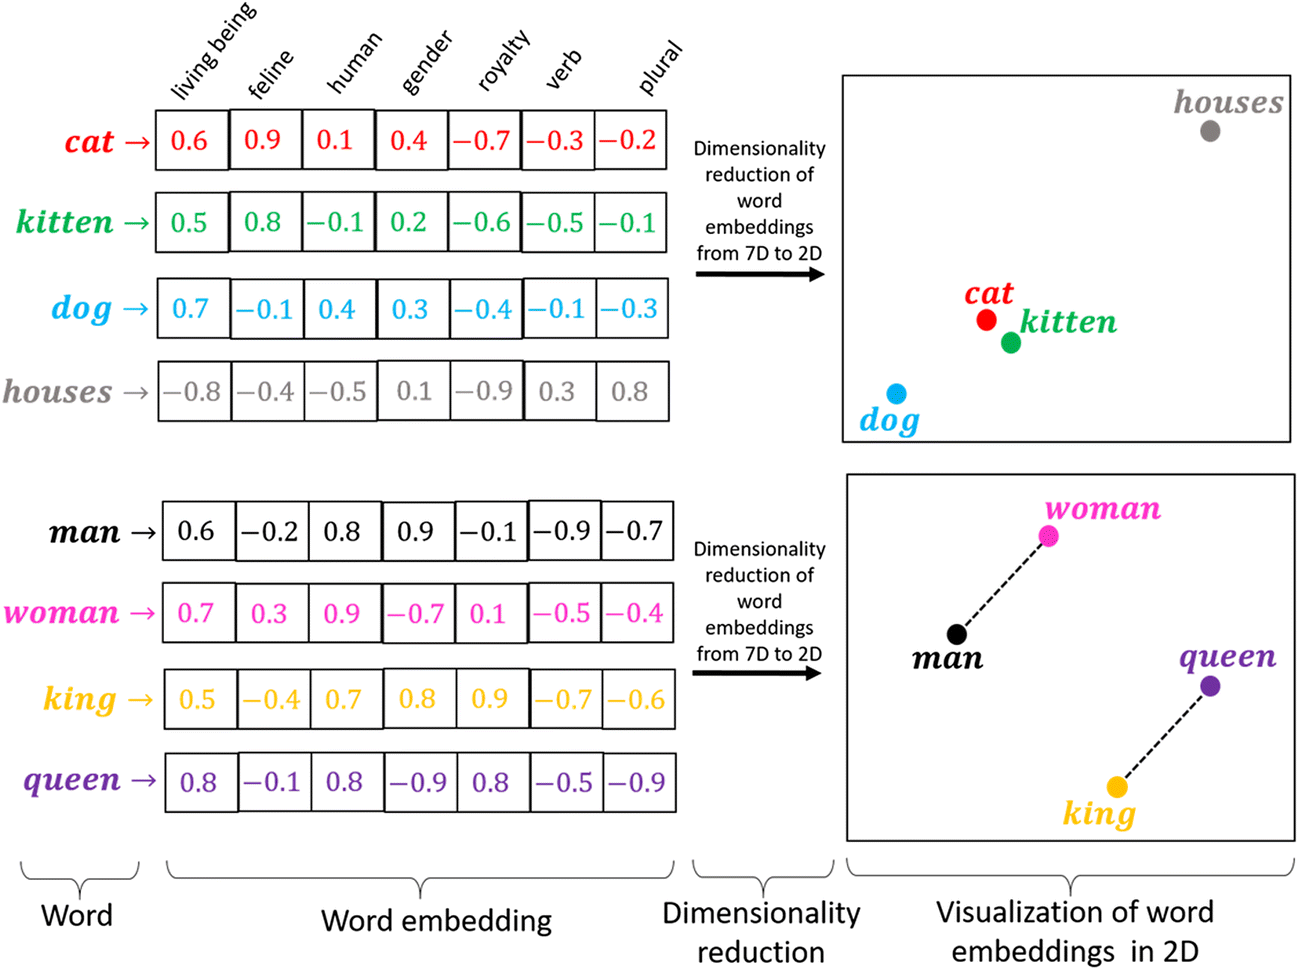

([source](https://www.analyticsvidhya.com/blog/2021/07/feature-extraction-and-embeddings-in-nlp-a-beginners-guide-to-understand-natural-language-processing/))

For wor2vec there are 2 possible approaches for learning the representations - predicting a word from its context (continuous bag-of-words) and predicting the context from a word (skipgram):

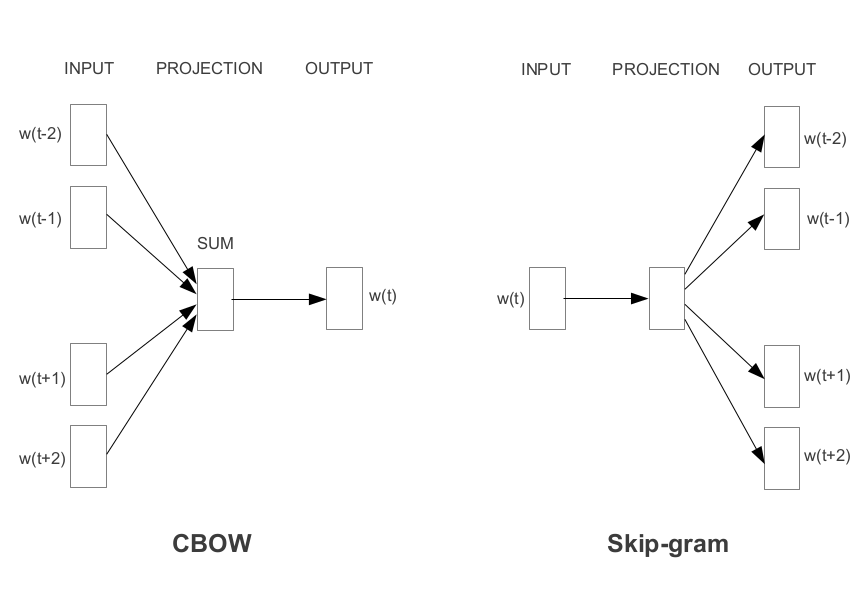

([source](https://arxiv.org/abs/1301.3781))

Let's try to replace the pretrained embeddings with our own word2vec model using the `gensim` library:

In [ ]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

# We need to get the words back from the indices
word_index = tf.keras.datasets.imdb.get_word_index()
inverted_word_index = dict(
    (i + 2, word) for (word, i) in word_index.items()
)
inverted_word_index[0] = "[BLANK]"
inverted_word_index[1] = "[START]"
inverted_word_index[2] = "[OOV]"

# Dekódujeme celý trénovací dataset
Xtrain_decoded = [[inverted_word_index[i] for i in sentence] for sentence in Xtrain]

In [ ]:
w2v_model = Word2Vec(sentences=Xtrain_decoded, vector_size=100, window=10, min_count=1, workers=4)
w2v_model.train(Xtrain_decoded, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)

We then need to port the learned embeddings to keras:

In [ ]:
keyed_vectors = w2v_model.wv  # structure holding the result of training
weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array

word2vec_layer = tf.keras.layers.Embedding(
    input_dim=weights.shape[0],
    output_dim=weights.shape[1],
    weights=[weights],
    trainable=False,
)

In [ ]:
input_sequence = tf.keras.Input(shape=(max_review_length,))
embedding_sequence = word2vec_layer(input_sequence)
x = tf.keras.layers.LSTM(100)(embedding_sequence)
y = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# TensorFlow model definition
model = tf.keras.Model(inputs=input_sequence, outputs=y)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer="adam", metrics=["accuracy"])

print(model.summary())

In [ ]:
# Train the model
history = model.fit(Xtrain, Ytrain, 
                    validation_data=(Xval, Yval), 
                    batch_size = 128, # default 32
                    epochs=5)

In [ ]:
# Evaluation
test_loss, test_acc = model.evaluate(Xtest, Ytest, verbose = 0)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

## LSTM with dropout

As we know, dropout is one of the most used forms of regularization. In an RNN, we can use dropout in 2 ways:
* `dropout` uses standard drouput on the layer inputs
* `recurrent_dropout` uses dropout on the *recurrent* input - i. e. the output from the previous step

In [ ]:
# Create a model
input_sequence = tf.keras.Input(shape=(max_review_length,))
embedding_sequence = tf.keras.layers.Embedding(input_dim = N, output_dim = embedding_vector_length, input_length = max_review_length)(input_sequence)
x = tf.keras.layers.LSTM(100, recurrent_dropout=0.2)(embedding_sequence)
y = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# TensorFlow model definition
model = tf.keras.Model(inputs=input_sequence, outputs=y)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer="adam", metrics=["accuracy"])

print(model.summary())

In [ ]:
# Train the model
history = model.fit(Xtrain, Ytrain, 
                    validation_data=(Xval, Yval), 
                    batch_size = 128, # default 32
                    epochs=5)

In [ ]:
# Model evaluation
test_loss, test_acc = model.evaluate(Xtest, Ytest, verbose = 0)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

## LSTM with multiple layers

By default, an RNN layer in keras doesn't actually return the full output, only the recurrent output. IF we want to use multiple layers, we need to have the full output of the first layer by setting the `return_sequences` argument.

In [ ]:
# Create a model
input_sequence = tf.keras.Input(shape=(max_review_length,))
embedding_sequence = tf.keras.layers.Embedding(input_dim = N, output_dim = embedding_vector_length, input_length = max_review_length)(input_sequence)
x = tf.keras.layers.LSTM(64, return_sequences = True)(embedding_sequence)
x = tf.keras.layers.LSTM(32)(x)
y = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# TensorFlow model definition
model = tf.keras.Model(inputs=input_sequence, outputs=y)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer="adam", metrics=["accuracy"])

print(model.summary())

In [ ]:
# Train the model
history = model.fit(Xtrain, Ytrain, 
                    validation_data=(Xval, Yval), 
                    batch_size = 128, # default 32
                    epochs=5)

In [ ]:
# Model evaluation
test_loss, test_acc = model.evaluate(Xtest, Ytest, verbose = 0)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

# Bidirectional RNNs

Bisirectional RNNs process the same sequence from both ends in parallel. The output has double the dimension - an embedding from both ends of the sequence.

In [ ]:
# Create a model
input_sequence = tf.keras.Input(shape=(max_review_length,))
embedding_sequence = tf.keras.layers.Embedding(input_dim = N, output_dim = embedding_vector_length, input_length = max_review_length)(input_sequence)
# Bidirectional combination
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=100))(embedding_sequence)
y = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# TensorFlow model definition
model = tf.keras.Model(inputs=input_sequence, outputs=y)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer="adam", metrics=["accuracy"])

print(model.summary())

In [ ]:
# Train the model
history = model.fit(Xtrain, Ytrain, 
                    validation_data=(Xval, Yval), 
                    batch_size = 128, # default 32
                    epochs=5)

In [ ]:
# Model evaluation
test_loss, test_acc = model.evaluate(Xtest, Ytest, verbose = 0)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)